# ASSIGNMENT

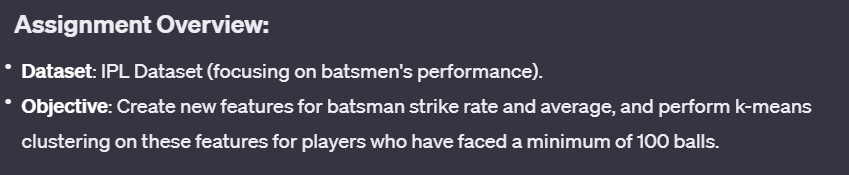

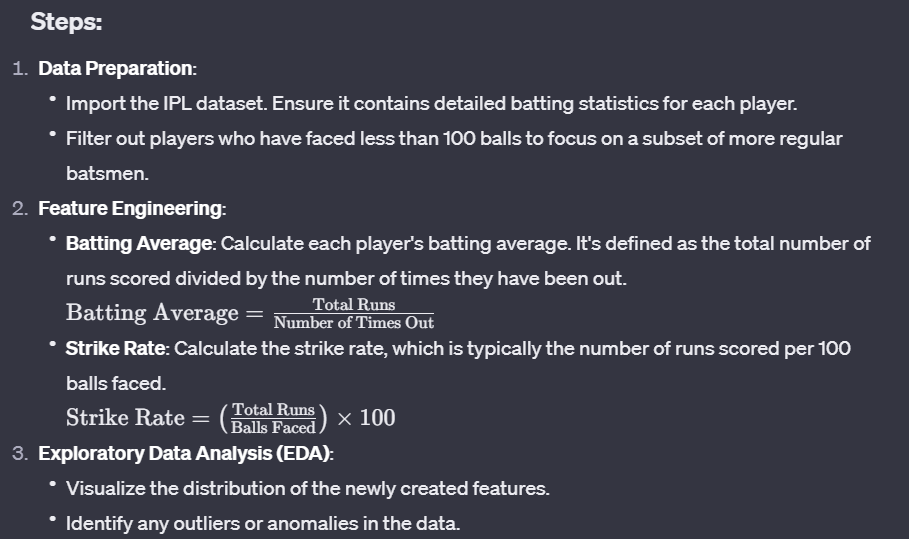

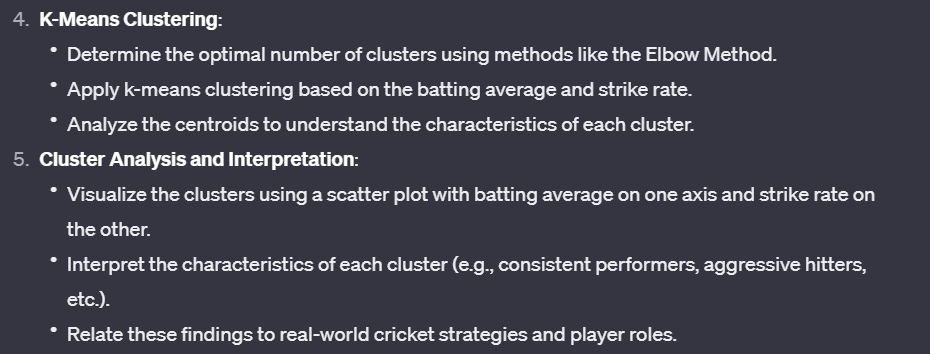

# SOLUTION

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest

# ==============================
# 1) DATA PREP
# ==============================

In [3]:
df = pd.read_csv("IPL_Ball_by_Ball_2008_2022.csv")

In [4]:
# keep regular batsmen (>=100 balls faced)
eligible_batsman = df['batter'].value_counts()[df['batter'].value_counts() > 100].index
new_df = df[df['batter'].isin(eligible_batsman)]

# ==============================
# 2) FEATURE ENGINEERING
# ==============================

In [5]:
runs = new_df.groupby('batter')['batsman_run'].sum()                     # total runs
balls = new_df['batter'].value_counts()                                  # balls faced
outs  = new_df.groupby('player_out')['isWicketDelivery'].sum()           # dismissals (sum of wicket deliveries)
outs  = outs.reindex(runs.index, fill_value=0)                            # align to batters

In [6]:
avg_df = (runs / outs.replace(0, np.nan)).reset_index()                   # avoid div/0
avg_df.columns = ['batsman', 'average']

In [7]:
sr_df  = ((runs / balls) * 100).reset_index()
sr_df.columns = ['batsman', 'strike_rate']

In [8]:
final_df = avg_df.merge(sr_df, on='batsman').dropna().reset_index(drop=True)
X = final_df[['average', 'strike_rate']].values

# ==============================
# 3) EDA — DISTRIBUTIONS
# ==============================

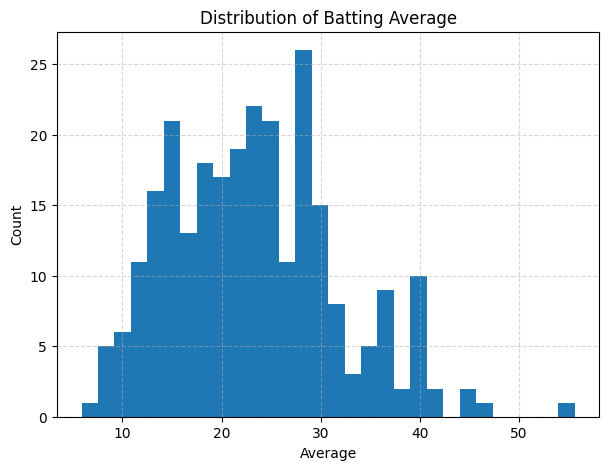

In [9]:
plt.figure(figsize=(7,5))
plt.hist(final_df['average'], bins=30)
plt.title("Distribution of Batting Average"); plt.xlabel("Average"); plt.ylabel("Count"); plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

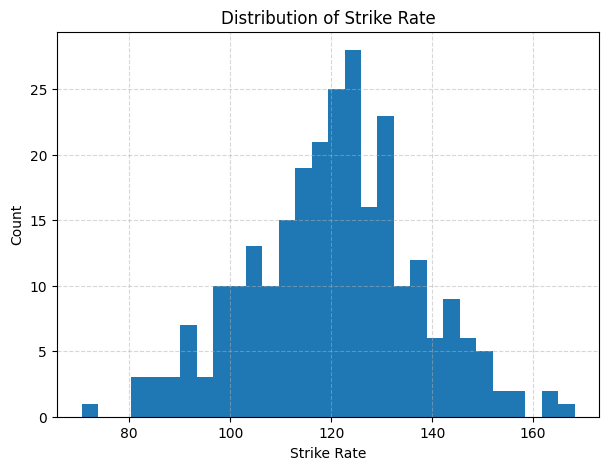

In [10]:
plt.figure(figsize=(7,5))
plt.hist(final_df['strike_rate'], bins=30)
plt.title("Distribution of Strike Rate"); plt.xlabel("Strike Rate"); plt.ylabel("Count"); plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

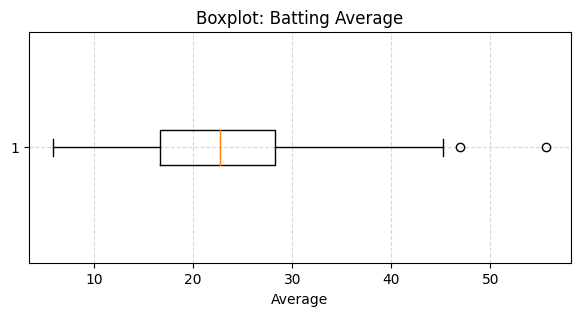

In [11]:
plt.figure(figsize=(7,3))
plt.boxplot(final_df['average'].dropna(), vert=False)
plt.title("Boxplot: Batting Average"); plt.xlabel("Average"); plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

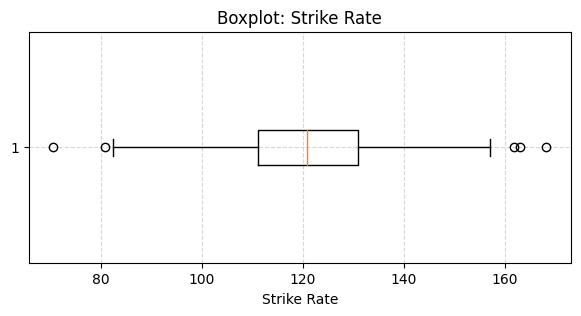

In [12]:

plt.figure(figsize=(7,3))
plt.boxplot(final_df['strike_rate'].dropna(), vert=False)
plt.title("Boxplot: Strike Rate"); plt.xlabel("Strike Rate"); plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# ==============================
# 3B) OUTLIERS — IQR RULE (per feature)
# ==============================

In [13]:
def iqr_flags(s):
    q1 = s.quantile(0.25); q3 = s.quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5*iqr
    high = q3 + 1.5*iqr
    return (s < low) | (s > high), low, high

final_df['outlier_avg'], avg_low, avg_high = iqr_flags(final_df['average'])
final_df['outlier_sr'],  sr_low,  sr_high  = iqr_flags(final_df['strike_rate'])
final_df['outlier_any_iqr'] = final_df['outlier_avg'] | final_df['outlier_sr']

print(f"IQR thresholds -> Avg: [{avg_low:.2f}, {avg_high:.2f}] | SR: [{sr_low:.2f}, {sr_high:.2f}]")
print(f"Outliers by IQR: {final_df['outlier_any_iqr'].sum()} players")

outliers_iqr = final_df[final_df['outlier_any_iqr']].sort_values(['average','strike_rate'], ascending=False)
print("\nTop IQR outliers (head):")
print(outliers_iqr[['batsman','average','strike_rate']].head(10).to_string(index=False))

IQR thresholds -> Avg: [-0.64, 45.59] | SR: [81.35, 160.71]
Outliers by IQR: 7 players

Top IQR outliers (head):
      batsman   average  strike_rate
   MN van Wyk 55.666667   123.703704
     KL Rahul 46.927711   132.799182
   AD Russell 29.985294   168.234323
  BCJ Cutting 21.636364   163.013699
Kuldeep Yadav 17.500000    80.769231
    K Gowtham 13.285714   161.739130
   RT Ponting 11.375000    70.542636


# ==============================
# 3C) ANOMALIES — MULTIVARIATE (IsolationForest)
# ==============================

In [14]:
iso = IsolationForest(random_state=42, contamination='auto')
iso_labels = iso.fit_predict(X)                  # -1 = anomaly
final_df['anomaly_iforest'] = (iso_labels == -1)
final_df['iforest_score'] = iso.decision_function(X)

In [15]:
print(f"\nIsolationForest anomalies: {final_df['anomaly_iforest'].sum()} players")
anoms_if = final_df[final_df['anomaly_iforest']].sort_values('iforest_score')  # more negative = more anomalous
print("\nTop IF anomalies (head):")
print(anoms_if[['batsman','average','strike_rate','iforest_score']].head(10).to_string(index=False))


IsolationForest anomalies: 47 players

Top IF anomalies (head):
    batsman   average  strike_rate  iforest_score
 MN van Wyk 55.666667   123.703704      -0.195937
 RT Ponting 11.375000    70.542636      -0.191281
 SL Malinga  5.866667    85.436893      -0.168859
 AD Russell 29.985294   168.234323      -0.154248
  K Gowtham 13.285714   161.739130      -0.147335
BCJ Cutting 21.636364   163.013699      -0.118929
   KL Rahul 46.927711   132.799182      -0.117190
     Z Khan  8.357143    82.978723      -0.113346
   NK Patel 30.250000    97.580645      -0.108842
Rashid Khan 11.178571   146.261682      -0.108422


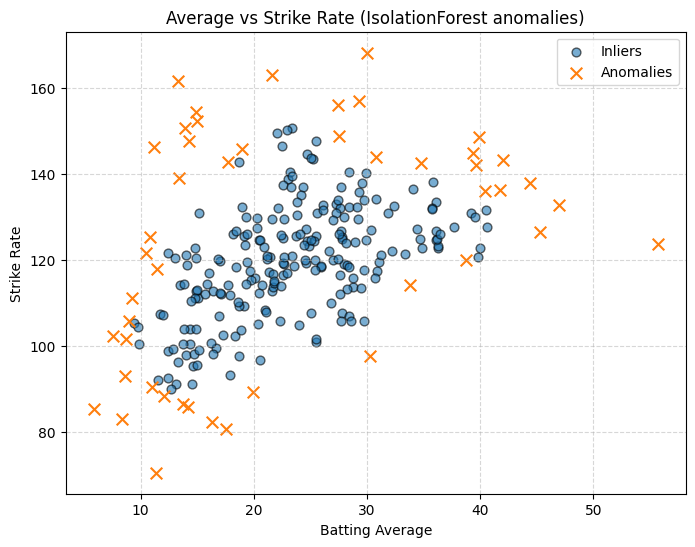

In [16]:
# visualize anomalies on scatter
plt.figure(figsize=(8,6))
mask = final_df['anomaly_iforest']
plt.scatter(final_df.loc[~mask, 'average'], final_df.loc[~mask, 'strike_rate'], s=40, alpha=0.6, edgecolor='k', label='Inliers')
plt.scatter(final_df.loc[mask, 'average'], final_df.loc[mask, 'strike_rate'], s=70, marker='x', label='Anomalies')
plt.title("Average vs Strike Rate (IsolationForest anomalies)")
plt.xlabel("Batting Average"); plt.ylabel("Strike Rate"); plt.grid(True, linestyle='--', alpha=0.5); plt.legend()
plt.show()

# ==============================
# 4) OPTIMAL k (ELBOW + SILHOUETTE)
# ==============================

# Elbow method

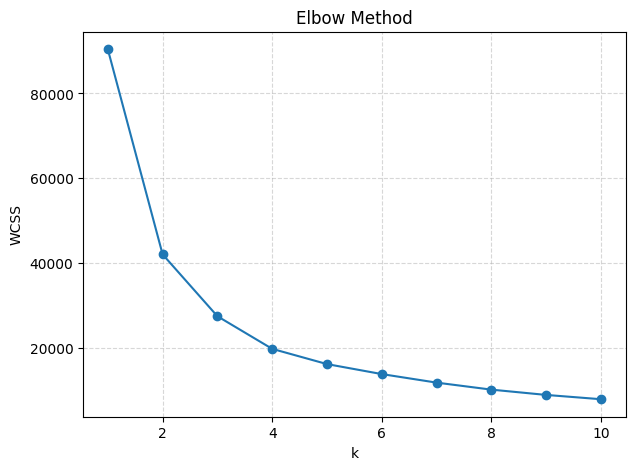

In [17]:
# Elbow method

wcss = []
for k in range(1, 11):
    km = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
    wcss.append(km.inertia_)

plt.figure(figsize=(7,5))
plt.plot(range(1,11), wcss, marker='o')
plt.title("Elbow Method"); plt.xlabel("k"); plt.ylabel("WCSS"); plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Silhouette

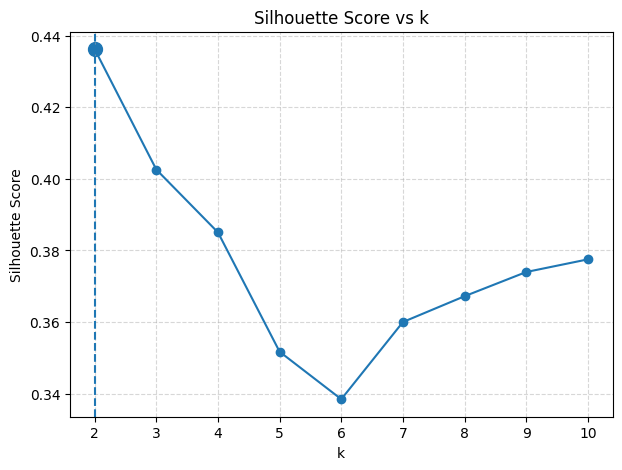

In [18]:
# Silhouette

sil_scores = []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X)
    sil_scores.append(silhouette_score(X, labels))
best_k = k_range[int(np.argmax(sil_scores))]
best_s = max(sil_scores)

plt.figure(figsize=(7,5))
plt.plot(list(k_range), sil_scores, marker='o')
plt.axvline(best_k, linestyle='--'); plt.scatter(best_k, best_s, s=100)
plt.title("Silhouette Score vs k"); plt.xlabel("k"); plt.ylabel("Silhouette Score"); plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

- From two graphs i choose ELBOW graph for best K- Value = 4

# ==============================
# 5) FINAL KMEANS + PLOT
# ==============================

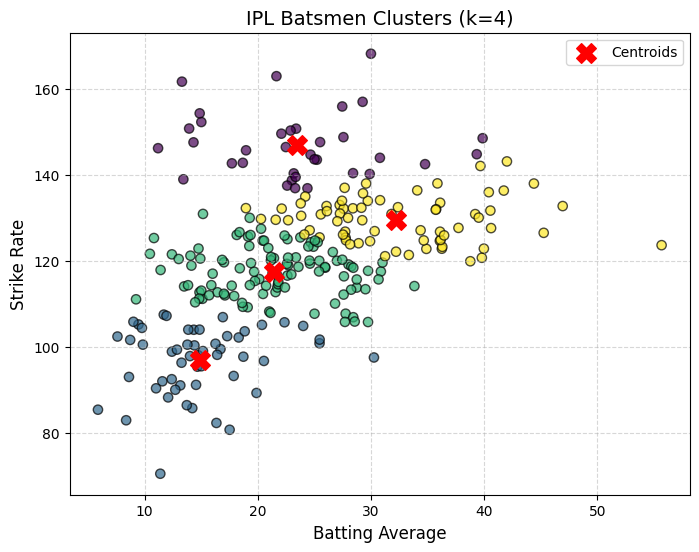

In [19]:
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42).fit(X)  #n_clusters = best_k for silhouette
final_df['cluster'] = kmeans.labels_

# k = 4
# kmeans_final = KMeans(n_clusters=k, n_init=10, random_state=42)
# final_labels = kmeans_final.fit_predict(X)

# final_df['cluster'] = final_labels

# k = 4

# kmeans = KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
# final_df['cluster'] = kmeans.labels_


plt.figure(figsize=(8,6))
plt.scatter(final_df["average"], final_df["strike_rate"], 
            c=final_df['cluster'], s=45, cmap='viridis', alpha=0.7, edgecolor='k')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
            s=200, c='red', marker='X', label='Centroids')
plt.title("IPL Batsmen Clusters (k=4)", fontsize=14)
plt.xlabel("Batting Average", fontsize=12)
plt.ylabel("Strike Rate", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()



# ==============================
# 6) CLUSTER INTERPRETATION
# ==============================


In [20]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['Avg_C','SR_C'])
centroids['cluster'] = centroids.index
print("\nCluster centroids:\n", centroids)


Cluster centroids:
        Avg_C        SR_C  cluster
0  23.459094  146.989734        0
1  14.904566   96.964628        1
2  21.401781  117.420676        2
3  32.213364  129.673561        3


In [21]:
for i, r in centroids.iterrows():
    avg, sr = r['Avg_C'], r['SR_C']
    if avg > 35 and sr > 130: role = "Elite match-winners (High Avg, High SR)"
    elif avg > 35 and sr <= 130: role = "Consistent anchors (High Avg, Mod SR)"
    elif avg <= 35 and sr > 130: role = "Aggressive hitters (Low Avg, High SR)"
    else: role = "Struggling/utility (Low Avg, Low SR)"
    print(f"Cluster {i}: {role}  -> Avg={avg:.1f}, SR={sr:.1f}")

Cluster 0: Aggressive hitters (Low Avg, High SR)  -> Avg=23.5, SR=147.0
Cluster 1: Struggling/utility (Low Avg, Low SR)  -> Avg=14.9, SR=97.0
Cluster 2: Struggling/utility (Low Avg, Low SR)  -> Avg=21.4, SR=117.4
Cluster 3: Struggling/utility (Low Avg, Low SR)  -> Avg=32.2, SR=129.7


# Optional: inspect examples

In [22]:
for c in sorted(final_df['cluster'].unique()):
    print(f"\nCluster {c} examples:", final_df[final_df['cluster']==c]['batsman'].head(5).tolist())


Cluster 0 examples: ['A Ashish Reddy', 'AB de Villiers', 'AD Russell', 'Abdul Samad', 'BCJ Cutting']

Cluster 1 examples: ['A Mishra', 'AA Jhunjhunwala', 'Anuj Rawat', 'B Kumar', 'CA Pujara']

Cluster 2 examples: ['A Badoni', 'AB Agarkar', 'AB McDonald', 'AD Hales', 'AD Mathews']

Cluster 3 examples: ['A Symonds', 'AC Gilchrist', 'AC Voges', 'AK Markram', 'AT Rayudu']


# Conclusion - 

- Cluster 0 – Aggressive hitters (Low Avg, High SR):
    Explosive batters like AB de Villiers and Andre Russell who can turn games quickly despite moderate averages.

- Cluster 1 – Struggling/utility (Low Avg, Low SR):
    Players such as CA Pujara and Anuj Rawat with limited batting impact, often filling secondary or supportive roles.

- Cluster 2 – Struggling/utility (Low Avg, Low SR):
    Mid-tier players like AD Hales and AD Mathews offering moderate contributions without standout performance.

- Cluster 3 – Struggling/utility (Low Avg, Low SR):
    Reliable names like Adam Gilchrist and Ambati Rayudu with decent consistency but not classified as elite due to average < 35.